In [1]:
import pandas as pd
import sklearn
from sklearn.datasets import fetch_openml
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from autofeat import FeatureSelector
from autosklearn.classification import AutoSklearnClassifier
import matplotlib.pyplot as plt
import shap

X, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True)
X['survived']=y

/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X

pclass                                             name     sex  \
0        1.0                    Allen, Miss. Elisabeth Walton  female   
1        1.0                   Allison, Master. Hudson Trevor    male   
2        1.0                     Allison, Miss. Helen Loraine  female   
3        1.0             Allison, Mr. Hudson Joshua Creighton    male   
4        1.0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   
...      ...                                              ...     ...   
1304     3.0                             Zabour, Miss. Hileni  female   
1305     3.0                            Zabour, Miss. Thamine  female   
1306     3.0                        Zakarian, Mr. Mapriededer    male   
1307     3.0                              Zakarian, Mr. Ortin    male   
1308     3.0                               Zimmerman, Mr. Leo    male   

          age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0     29.0000    0.0    0.0   24160  211.3375       B5        S    2    NaN   
1      0.9167    1.0    2.0  113781  151.5500  C22 C26        S   11    NaN   
2      2.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN    NaN   
3     30.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN  135.0   
4     25.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN    NaN   
...       ...    ...    ...     ...       ...      ...      ...  ...    ...   
1304  14.5000    1.0    0.0    2665   14.4542      NaN        C  NaN  328.0   
1305      NaN    1.0    0.0    2665   14.4542      NaN        C  NaN    NaN   
1306  26.5000    0.0    0.0    2656    7.2250      NaN        C  NaN  304.0   
1307  27.0000    0.0    0.0    2670    7.2250      NaN        C  NaN    NaN   
1308  29.0000    0.0    0.0  315082    7.8750      NaN        S  NaN    NaN   

                            home.dest survived  
0                        St Louis, MO        1  
1     Montreal, PQ / Chesterville, ON        1  
2     Montreal, PQ / Chesterville, ON        0  
3     Montreal, PQ / Chesterville, ON        0  
4     Montreal, PQ / Chesterville, ON        0  
...                               ...      ...  
1304                              NaN        0  
1305                              NaN        0  
1306                              NaN        0  
1307                              NaN        0  
1308                              NaN        0  

[1309 rows x 14 columns]

In [3]:
ProfileReport(X, title="AutoEDA Report", explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Dropping features with maximum null values and features with no direct contribution like name and ticket.

In [4]:
drop_columns=['boat','body','home.dest','cabin','name','ticket']
X.drop(drop_columns,inplace=True,axis=1)
# X['age']=X['age'].fillna(X['age'].mean())
X=X.dropna(subset=["fare","embarked"],how='any')

In [5]:
X

pclass     sex      age  sibsp  parch      fare embarked survived
0        1.0  female  29.0000    0.0    0.0  211.3375        S        1
1        1.0    male   0.9167    1.0    2.0  151.5500        S        1
2        1.0  female   2.0000    1.0    2.0  151.5500        S        0
3        1.0    male  30.0000    1.0    2.0  151.5500        S        0
4        1.0  female  25.0000    1.0    2.0  151.5500        S        0
...      ...     ...      ...    ...    ...       ...      ...      ...
1304     3.0  female  14.5000    1.0    0.0   14.4542        C        0
1305     3.0  female      NaN    1.0    0.0   14.4542        C        0
1306     3.0    male  26.5000    0.0    0.0    7.2250        C        0
1307     3.0    male  27.0000    0.0    0.0    7.2250        C        0
1308     3.0    male  29.0000    0.0    0.0    7.8750        S        0

[1306 rows x 8 columns]

## Creating test and train data

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X.drop('survived',axis=1),X['survived'],test_size=0.2,shuffle=True,stratify=X['survived'])

In [7]:
X_train.head(5)

pclass     sex   age  sibsp  parch    fare embarked
412      2.0    male  35.0    0.0    0.0  26.000        S
395      2.0  female  18.0    0.0    1.0  23.000        S
567      2.0    male  25.0    0.0    0.0  10.500        S
807      3.0  female   9.0    2.0    2.0  34.375        S
1252     3.0    male  44.0    0.0    0.0   8.050        S

## Considering pclass,sibsp,parch as numerical values and without feature engineering

In [8]:
numerical_minmax_features = ['pclass', 'sibsp','parch']
numerical_std_features = ['age', 'fare']
categorical_features = ['sex', 'embarked']  

# Numerical Preprocessing Pipeline
numerical_minmax_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])

numerical_std_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Categorical Preprocessing Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

# Combine Both Preprocessing Pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num_minmax', numerical_minmax_transformer, numerical_minmax_features),
        ('num_std', numerical_std_transformer, numerical_std_features),
        ('cat', categorical_transformer, categorical_features)])

In [9]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

In [10]:
X_train_1 = preprocessor.fit_transform(X_train_1)
X_test_1=preprocessor.transform(X_test_1)

/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Considering pclass,sibsp,parch as numerical values and with feature engineering

In [11]:
X_train_2 = X_train_1.copy()

In [12]:
X_test_2 = X_test_1.copy()

In [13]:
fsel=FeatureSelector(problem_type="classification",verbose=1,featsel_runs=20)

In [14]:
X_train_2=fsel.fit_transform(X_train_2,y_train)

[featsel] Scaling data...

2024-09-20 07:37:15,374 INFO: [featsel] Feature selection run 1/20


done.


2024-09-20 07:37:15,579 INFO: [featsel] Feature selection run 2/20
2024-09-20 07:37:15,746 INFO: [featsel] Feature selection run 3/20
2024-09-20 07:37:15,929 INFO: [featsel] Feature selection run 4/20
2024-09-20 07:37:16,120 INFO: [featsel] Feature selection run 5/20
2024-09-20 07:37:16,290 INFO: [featsel] Feature selection run 6/20
2024-09-20 07:37:16,458 INFO: [featsel] Feature selection run 7/20
2024-09-20 07:37:16,660 INFO: [featsel] Feature selection run 8/20
2024-09-20 07:37:16,837 INFO: [featsel] Feature selection run 9/20
2024-09-20 07:37:17,039 INFO: [featsel] Feature selection run 10/20
2024-09-20 07:37:17,189 INFO: [featsel] Feature selection run 11/20
2024-09-20 07:37:17,348 INFO: [featsel] Feature selection run 12/20
2024-09-20 07:37:17,499 INFO: [featsel] Feature selection run 13/20
2024-09-20 07:37:17,679 INFO: [featsel] Feature selection run 14/20
2024-09-20 07:37:17,865 INFO: [featsel] Feature selection run 15/20
2024-09-20 07:37:18,072 INFO: [featsel] Feature selectio

In [15]:
X_test_2=fsel.transform(X_test_2)

## Considering pclass,sibsp,parch as categorical values and without feature engineering

In [18]:
numerical_std_features = ['age', 'fare']
categorical_features_2 = ['sex', 'embarked','pclass', 'sibsp','parch']  

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Categorical Preprocessing Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

# Combine Both Preprocessing Pipelines
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num_std', numerical_std_transformer, numerical_std_features),
        ('cat', categorical_transformer, categorical_features_2)])

In [19]:
X_train_3 = X_train.copy()
X_test_3 = X_test.copy()

In [20]:
X_train_3 = preprocessor_2.fit_transform(X_train_3)
X_test_3 = preprocessor_2.transform(X_test_3)

/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Considering pclass,sibsp,parch as categorical values and with feature engineering

In [34]:
X_train_4=X_train_3.copy()
X_test_4=X_test_3.copy()

In [35]:
fsel_1=FeatureSelector(problem_type="classification",verbose=1,featsel_runs=80)

In [36]:
X_train_4=fsel_1.fit_transform(X_train_4,y_train)
X_test_4=fsel_1.transform(X_test_4)

2024-09-20 07:49:19,651 INFO: [featsel] Feature selection run 1/80


[featsel] Scaling data...done.


2024-09-20 07:49:22,090 INFO: [featsel] Feature selection run 2/80
2024-09-20 07:49:23,027 INFO: [featsel] Feature selection run 3/80
2024-09-20 07:49:24,007 INFO: [featsel] Feature selection run 4/80
2024-09-20 07:49:26,322 INFO: [featsel] Feature selection run 5/80
2024-09-20 07:49:27,670 INFO: [featsel] Feature selection run 6/80
2024-09-20 07:49:30,055 INFO: [featsel] Feature selection run 7/80
2024-09-20 07:49:32,333 INFO: [featsel] Feature selection run 8/80
2024-09-20 07:49:33,271 INFO: [featsel] Feature selection run 9/80
2024-09-20 07:49:34,832 INFO: [featsel] Feature selection run 10/80
2024-09-20 07:49:35,766 INFO: [featsel] Feature selection run 11/80
2024-09-20 07:49:38,032 INFO: [featsel] Feature selection run 12/80
2024-09-20 07:49:40,107 INFO: [featsel] Feature selection run 13/80
2024-09-20 07:49:42,612 INFO: [featsel] Feature selection run 14/80
2024-09-20 07:49:43,482 INFO: [featsel] Feature selection run 15/80
2024-09-20 07:49:46,056 INFO: [featsel] Feature selectio

## Running Auto SKLearn to train all 4 model variants

In [37]:
def train_auto_sklearn(X_train, y_train):
    # Train the model using Auto-sklearn
    automl = AutoSklearnClassifier(
        time_left_for_this_task=1200,
        per_run_time_limit=115,
        n_jobs=8,
        memory_limit=5120
    )
    automl.fit(X_train, y_train)
    
    
    
    return automl


def evaluate_model(model, X_test, y_test,name):
    # Evaluate the model
    accuracy = model.score(X_test, y_test)
    print(f'{name} Test accuracy: {accuracy:.3f}')
    
    return accuracy

In [38]:
model_1=train_auto_sklearn(X_train_1, y_train)
model_2=train_auto_sklearn(X_train_2, y_train)
model_3=train_auto_sklearn(X_train_3, y_train)
model_4=train_auto_sklearn(X_train_4, y_train)

/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


[WARNING] [2024-09-20 07:56:38,753:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


[WARNING] [2024-09-20 08:36:29,057:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-09-20 08:36:29,272:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


In [117]:
model1_eval=evaluate_model(model_1,X_test_1,y_test,"Model_1")
model2_eval=evaluate_model(model_2,X_test_2,y_test,"Model_2")
model3_eval=evaluate_model(model_3,X_test_3,y_test,"Model_3")
model4_eval=evaluate_model(model_4,X_test_4,y_test,"Model_4")

Model_1 Test accuracy: 0.794
Model_2 Test accuracy: 0.790
Model_3 Test accuracy: 0.779
Model_4 Test accuracy: 0.802


## Training AutoSklearn model on raw data without pre-processing

In [69]:
model_0=train_auto_sklearn(X_train, y_train)
model0_eval=evaluate_model(model_0,X_test,y_test,"Model_0")

/home/abhishek/miniconda3/envs/autosklearn-env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


Model_0 Test accuracy: 0.802


## Creating SHAP values and plotting for Model without AutoFeat and Model with AUtoFeat (Only 1 feature selected for male passenger)

In [126]:
explainer = shap.KernelExplainer(model_1.predict_proba,X_train_1)
shap_values = explainer.shap_values(X_test_1)

[WARNING] [2024-09-20 14:24:24,974:shap] Using 1044 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/262 [00:00<?, ?it/s]

In [139]:
shap.summary_plot(shap_values, X_test_1,feature_names=preprocessor.get_feature_names_out())

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [141]:
plt.savefig('shap_summary_plot_without_feature_selection.png')

In [143]:
explainer_4 = shap.KernelExplainer(model_4.predict_proba,X_train_4)
shap_values_4 = explainer_4.shap_values(X_test_4)

[WARNING] [2024-09-20 16:27:53,258:shap] Using 1044 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/262 [00:00<?, ?it/s]

In [148]:
shap.summary_plot(shap_values_4, X_test_4,feature_names=preprocessor_2.get_feature_names_out()[[fsel_1.original_columns_.index(i) for i in fsel_1.good_cols_]])
plt.savefig('shap_summary_plot_with_feature_selection.png')

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [187]:
import pickle

Model_0_file = 'second_best_model.pkl'
with open(Model_0_file, 'wb') as file:
    pickle.dump(model_0, file)

Model_4_file = 'Best_model.pkl'
with open(Model_4_file, 'wb') as file:
    pickle.dump(model_4, file)

## Observations

### We trained 4 models after data preprocessing.

1. Model_1 -  Data Considering pclass,sibsp,parch as numerical values and without feature engineering

    Features as below:

    'num_minmax__pclass', 'num_minmax__sibsp', 'num_minmax__parch','num_std__age', 'num_std__fare', 'cat__sex_female','cat__sex_male', 'cat__embarked_C', 'cat__embarked_Q',
    'cat__embarked_S'

2. Model_2 - Data Considering pclass,sibsp,parch as numerical values and with feature engineering using Autofeat

    Features as below:

    'cat__sex_female', 'num_std__age', 'num_minmax__pclass',
    'num_minmax__sibsp', 'cat__embarked_C', 'num_std__fare'

3. Model_3 - Data Considering pclass,sibsp,parch as categorical values and without feature engineering

    Features as below:

    'num_std__age', 'num_std__fare', 'cat__sex_female', 'cat__sex_male', 'cat__embarked_C', 'cat__embarked_Q', 'cat__embarked_S', 'cat__pclass_1.0', 'cat__pclass_2.0',
    'cat__pclass_3.0', 'cat__sibsp_0.0', 'cat__sibsp_1.0', 'cat__sibsp_2.0', 'cat__sibsp_3.0', 'cat__sibsp_4.0', 'cat__sibsp_5.0', 'cat__sibsp_8.0', 'cat__parch_0.0',
    'cat__parch_1.0', 'cat__parch_2.0', 'cat__parch_3.0', 'cat__parch_4.0', 'cat__parch_5.0', 'cat__parch_6.0', 'cat__parch_9.0'

4. Model_4 - Data Considering pclass,sibsp,parch as categorical values and with feature engineering using Autofeat

    Features as below:

    'cat__sex_male'


We considered pclass,sibsp,parch as both categorical and numerical for different models as there were few unique numerical values and AutoEDA using Dataprep was considering them as categorical values, while AutoEDA using Ydata_profiling was considering them as numerical. So wanted to experiment with both.
Both the AutoEDA tools were useful. While Ydata_profiling provided quick view of features which have high correlation with Survival, Dataprep provides more interactable HTML report. Moreover the way both have different interpretation for categorical and numerical variables pushed us to explore different variations in the model.

Feature selection with AutoFeat was providing different results for different runs. In our case, Model_2 and Model_4 were trained on data processed using Autofeat.
On both occassions, autofeat provided either only 'cat__sex_male' as the selected feature, or sometime very rarely a mix of other featuers.
Hence we tried to provide both variations in the model training.

Following accuracies were observed for the trained ensemble modesl with AutoSkLearn


Model_1 Test accuracy: 0.794

Model_2 Test accuracy: 0.790

Model_3 Test accuracy: 0.779

Model_4 Test accuracy: 0.802


Further we performed SHAP value analysis for the top 2 best performing models and observe that both models consider male passenger as an import feature for predicting Chances of survival.


### Printing SHAP values

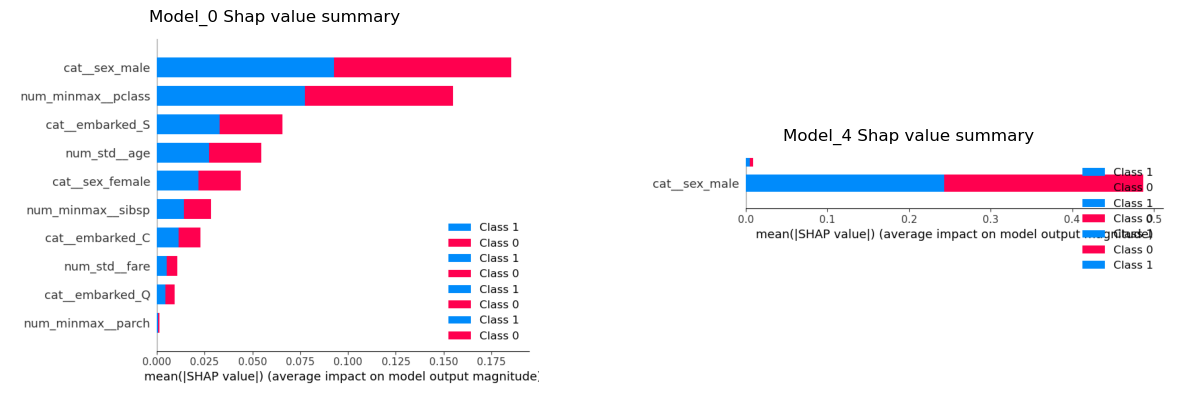

In [186]:
from PIL import Image
%matplotlib inline

img1 = Image.open("shap_summary_plot_without_feature_selection.png")
img2 = Image.open("shap_summary_plot_with_feature_selection.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(img1)
ax1.set_title("Model_0 Shap value summary")
ax1.axis('off')
ax2.imshow(img2)
ax2.set_title("Model_4 Shap value summary")
ax2.axis('off')
plt.show()